# **Finding Lane Lines on the Road** 


## Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import math
import os

%matplotlib inline

## Dump frames

In [2]:
def dump_frames(read_dir, store_dir, files):
    for item in files:
        vidcap = cv2.VideoCapture("%s/%s" % (read_dir, item))
        retval,image = vidcap.read()
        count = 0
        while retval:
            cv2.imwrite("%s/%s-%04d.jpg" % (store_dir, item, count), image)
            count += 1
            retval,image = vidcap.read()

In [3]:
video_dir = 'test_videos'
video_list = os.listdir(video_dir)

dump_dir = 'frame_images'

# dump once
if not os.path.exists(dump_dir):
    os.makedirs(dump_dir)
    dump_frames(video_dir, dump_dir, video_list)


## Test Images

I randomly choosed samples depending on intuition.

In [4]:
sample_dir = 'test_images'
sample_files = os.listdir(sample_dir)
[print(sample) for sample in sample_files]
sample_images = [plt.imread(sample_dir + '/' + item) for item in sample_files]
print([image.shape for image in sample_images])
# check out - video sample's resolution is different

challenge.mp4-0002.jpg
challenge.mp4-0103.jpg
challenge.mp4-0145.jpg
challenge.mp4-0155.jpg
solidWhiteCurve.jpg
solidWhiteRight.jpg
solidWhiteRight.mp4-0006.jpg
solidYellowCurve.jpg
solidYellowCurve2.jpg
solidYellowLeft.jpg
solidYellowLeft.mp4-0317.jpg
whiteCarLaneSwitch.jpg
[(720, 1280, 3), (720, 1280, 3), (720, 1280, 3), (720, 1280, 3), (540, 960, 3), (540, 960, 3), (540, 960, 3), (540, 960, 3), (540, 960, 3), (540, 960, 3), (540, 960, 3), (540, 960, 3)]


## Helper Functions

### HSV Color Space
I choose HSV as the best color space for edge detection as I refered to several papers.

In [5]:
def convert_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

### Set HSV Threshold for filtering lane colors ( white and yellow )
I used a tool that helped me check the thresholds. Thank you for sharing great tools. http://isda.ncsa.uiuc.edu/Im2Learn/doc/HSVThreshold.html

Note that the value of H range is 0 to 360. However, H/2 is used in the 24-bit HSV color space. The reason is that the number that can be represented in 8 bits is 255, but with H / 2, the precision can be reduced but the whole range can be represented.

In [6]:
def select_white_yellow(image):
    converted = convert_hsv(image)
    # white color mask, white in HSV is [  0   0 255]
    lower  = np.array([15, 0, 156])
    upper = np.array([ 255, 25, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask. yellow in HSV is [ 30 255 255]
    lower  = np.array([15, 100, 60])
    upper = np.array([30, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = mask)

### Region of Interest
As we have seen, the resolution of the sample videos are different. Use x, y by scaling.


In [7]:
# assumes that lane line is isosceles trapezoid.
def get_lane_vertices(width, height):
    
    bottom_left  = [width*0.05, height]
    bottom_right = [width*0.95, height]
    top_left     = [width*0.45, height*0.6]
    top_right    = [width*0.55, height*0.6]
    
    return np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)

### Image drawing on jupyter
Displaying images in parallel makes it easier to understand the process.

In [8]:
def show_images(images1, images2=None, cmap=None, save=False, name='save.png'):
    if images2 is not None:
        sets = 2
    else:
        sets = 1
    cols = 2
    rows = int((len(images1)+1)/cols) * sets
    plt.figure(figsize=(cols*10, rows*4))
    for i, image in enumerate(images1):
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.subplot(rows, cols, (i*sets)+1)
        plt.imshow(image, cmap=cmap)
        if images2 is not None:
            cmap = 'gray' if len(images2[i].shape)==2 else cmap
            plt.subplot(rows, cols, (i*sets)+2)
            plt.imshow(images2[i], cmap=cmap)
        if save:
            path = 'test_images_output/' + name
            plt.savefig(path)
    plt.show()
    

### Line Averaging

Left and right lines have different slopes. Simply weight the line lengths and average the slope and intercept. In addition, it returns the length of the longest line to distingush solid and segmented lines.

In [9]:
def average_slope_intercept(lines):
    left_lines = [] # (slope, intercept)
    left_weights = [] # (length)
    left_max_length = 0
    left_solid = False
    right_lines = [] # (slope, intercept)
    right_weights = [] # (length)
    right_solid = False
    right_max_length = 0
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if(x1==x2): # avoid device by 0
                continue
            elif(y1==y2): # ignore vertical line
                continue
            else:
                slope = (y2-y1)/(x2-x1)
                intercept = y1 - slope*x1
                length = math.hypot(x2 - x1, y2 - y1)
                
                if slope < 0:
                    # if slope < - 0.8 or slope > -0.5: # TODO: use distribution or something else rather than fixed range
                    #     if length < 100:
                    #         continue
                    left_lines.append((slope, intercept))
                    left_weights.append((length))
                    left_max_length = length if length > left_max_length else left_max_length
                else:
                    # if slope > 0.8 or slope < 0.5: # TODO: use distribution or something else rather than fixed range
                    #     if length < 100:
                    #         continue
                    right_lines.append((slope, intercept))
                    right_weights.append((length))
                    right_max_length = length if length > right_max_length else right_max_length
    
    # add more weight to longer lines
    left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
    right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)>0 else None
    
    return left_lane, right_lane, left_max_length, right_max_length

 ### Line extend
 
 Extends to a line of the size that fits the angle of the target image.

In [10]:
def extend_line(image, line, top=0.6):
    
    y1 = image.shape[0]
    y2 = y1*top
    
    slope, intercept = line
    
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return (x1, y1, x2, y2)

### OpenVC functions

Used OpenCV functions are mainly wrapped.

In [11]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_line(image, line, color=[255, 0, 0], thickness=15):
    image = np.copy(image)    
    x1,y1,x2,y2 = line
    cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

def hough_lines(img, rho=1, theta=np.pi/180, threshold=20, min_line_len=20, max_line_gap=10):
    return cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Build a Lane Finding Pipeline

### generate image vertices

In [12]:
image_vertices = [get_lane_vertices(image.shape[1], image.shape[0]) for image in sample_images]

### Color Filter
I tried to get a apropriate threshold for it. However it was hard to find a super set for whole samples by hand even though I have a great tool.
I'm sure I'll figure out better way such as Machine Learning or Deep Learning.

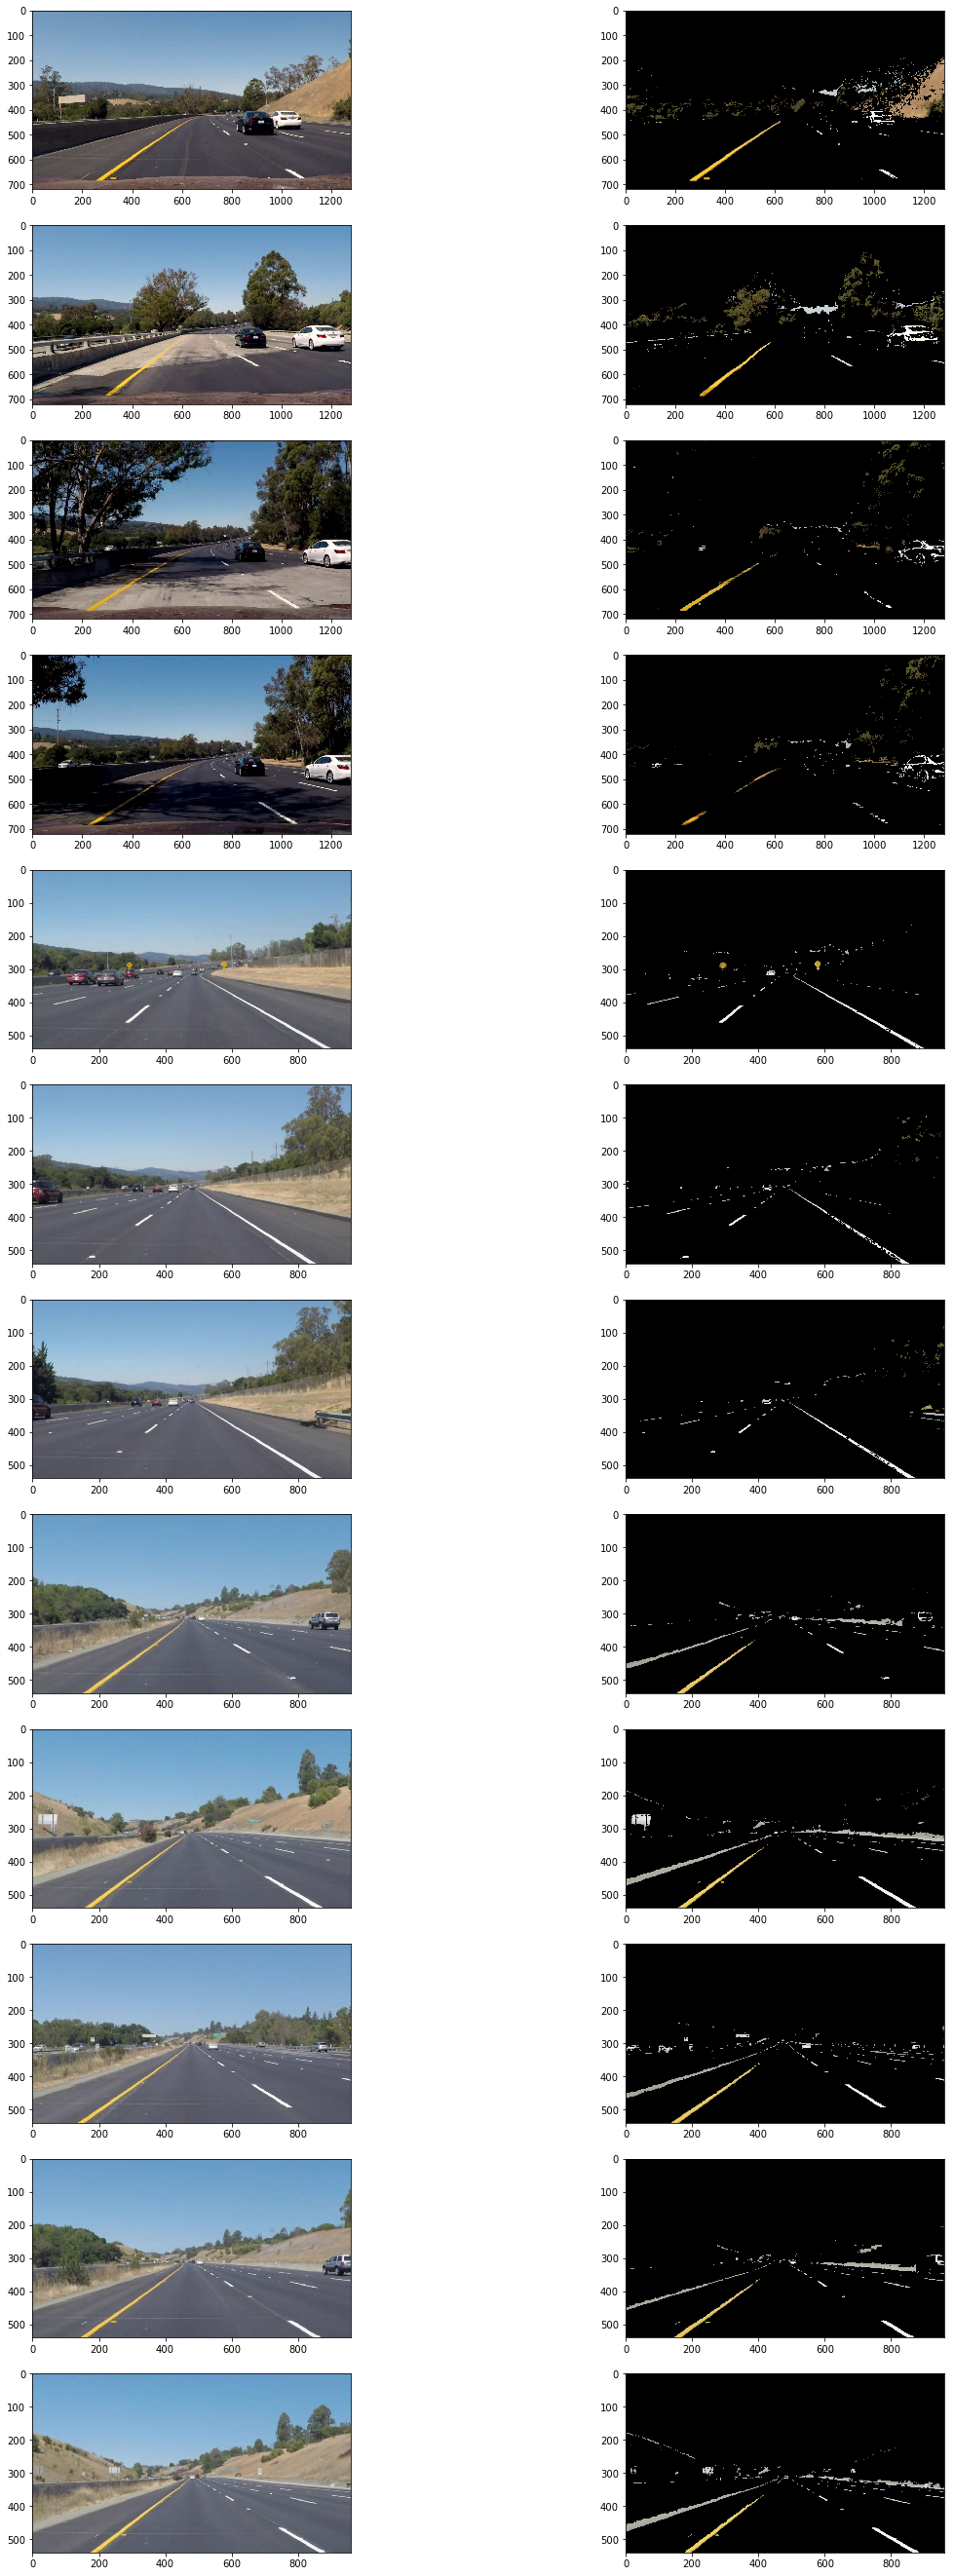

In [13]:
filter_images = [select_white_yellow(image) for image in sample_images]
show_images(sample_images, filter_images, save=True, name='filter.png')

### Gray Scale

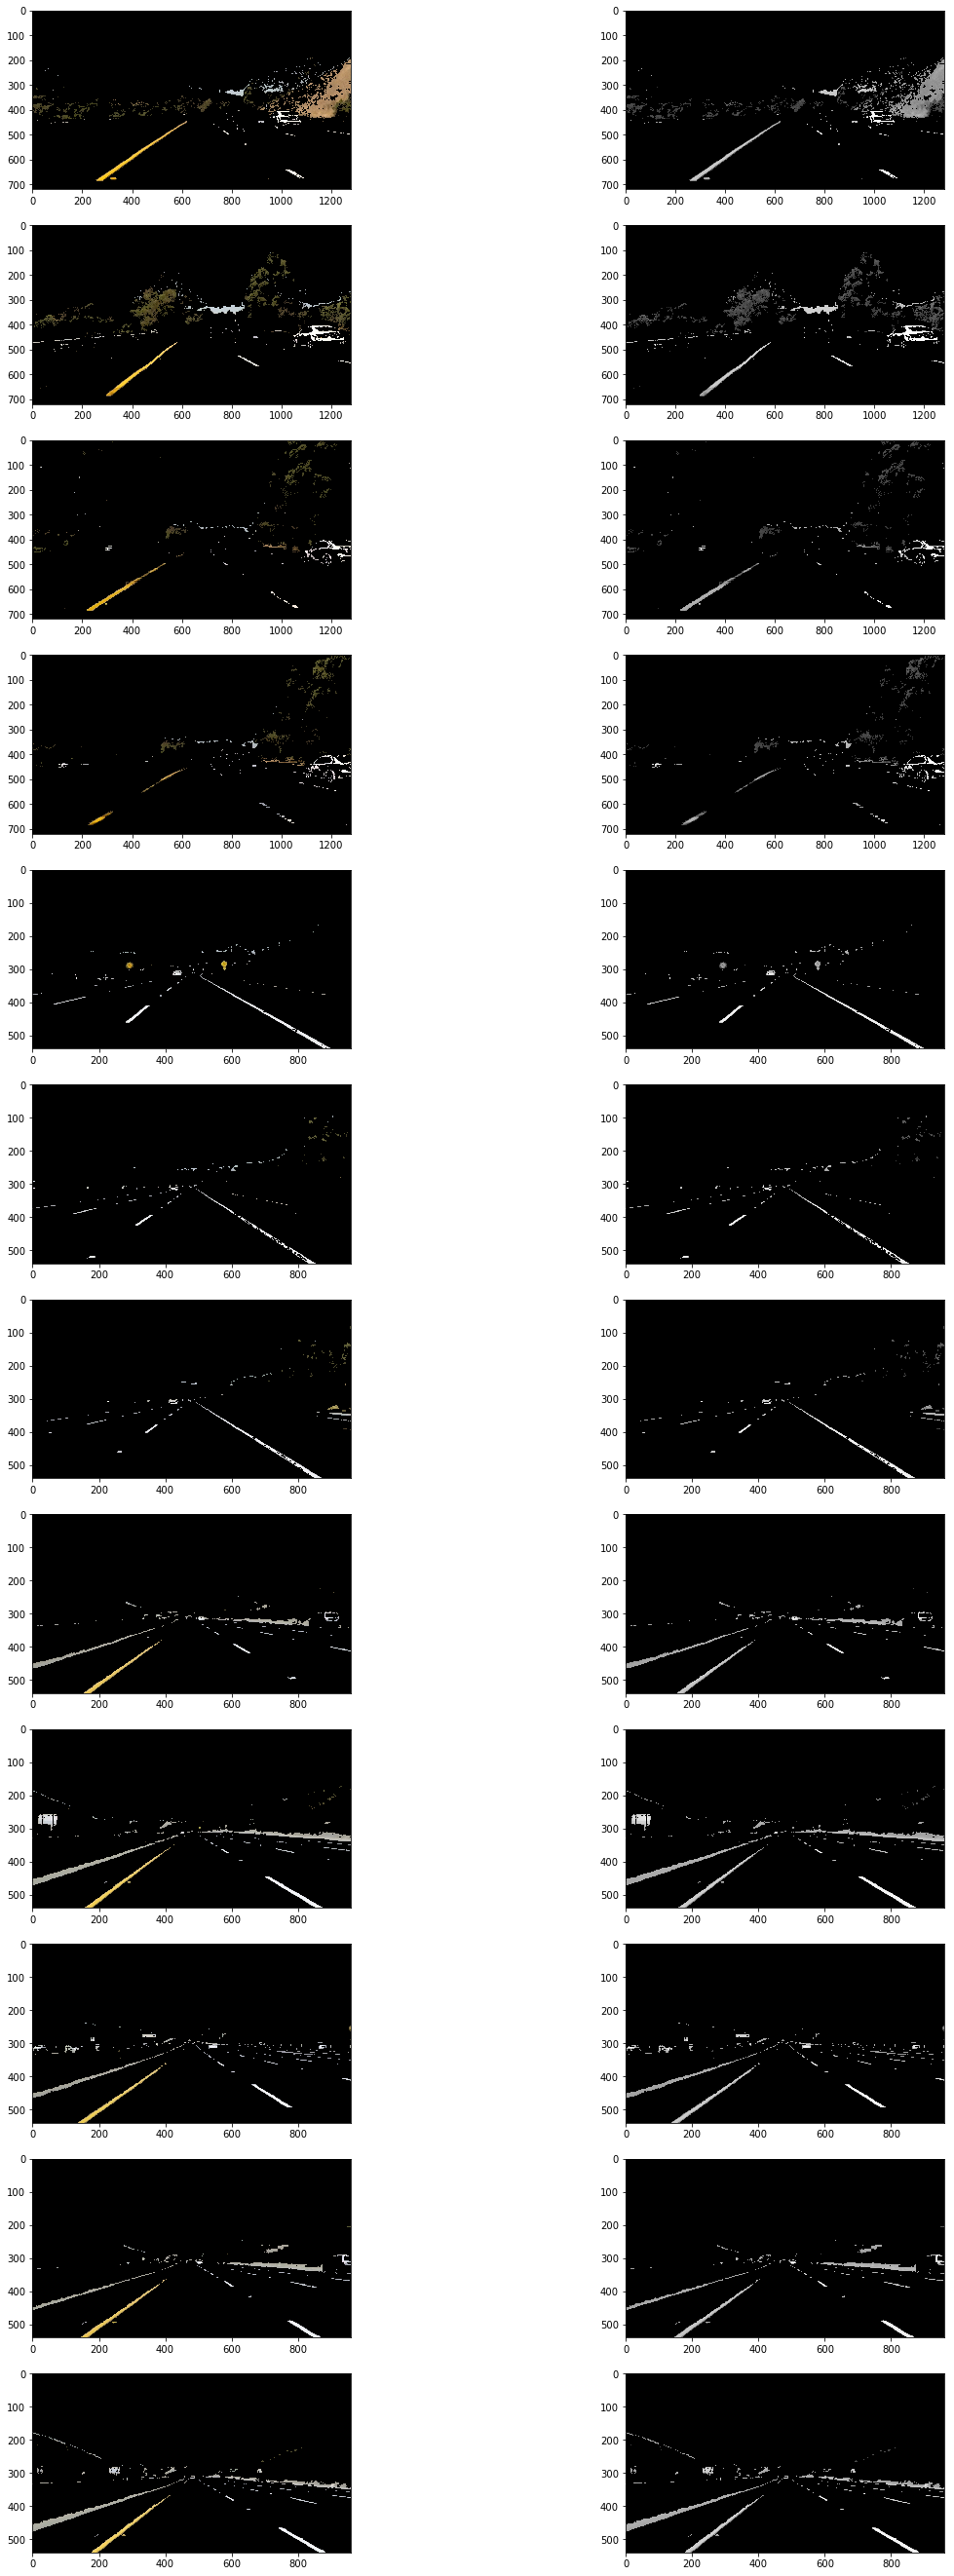

In [14]:
gray_images = [grayscale(item) for item in filter_images]
show_images(filter_images, gray_images, save=True, name='gray.png')

### Gaussian Blur

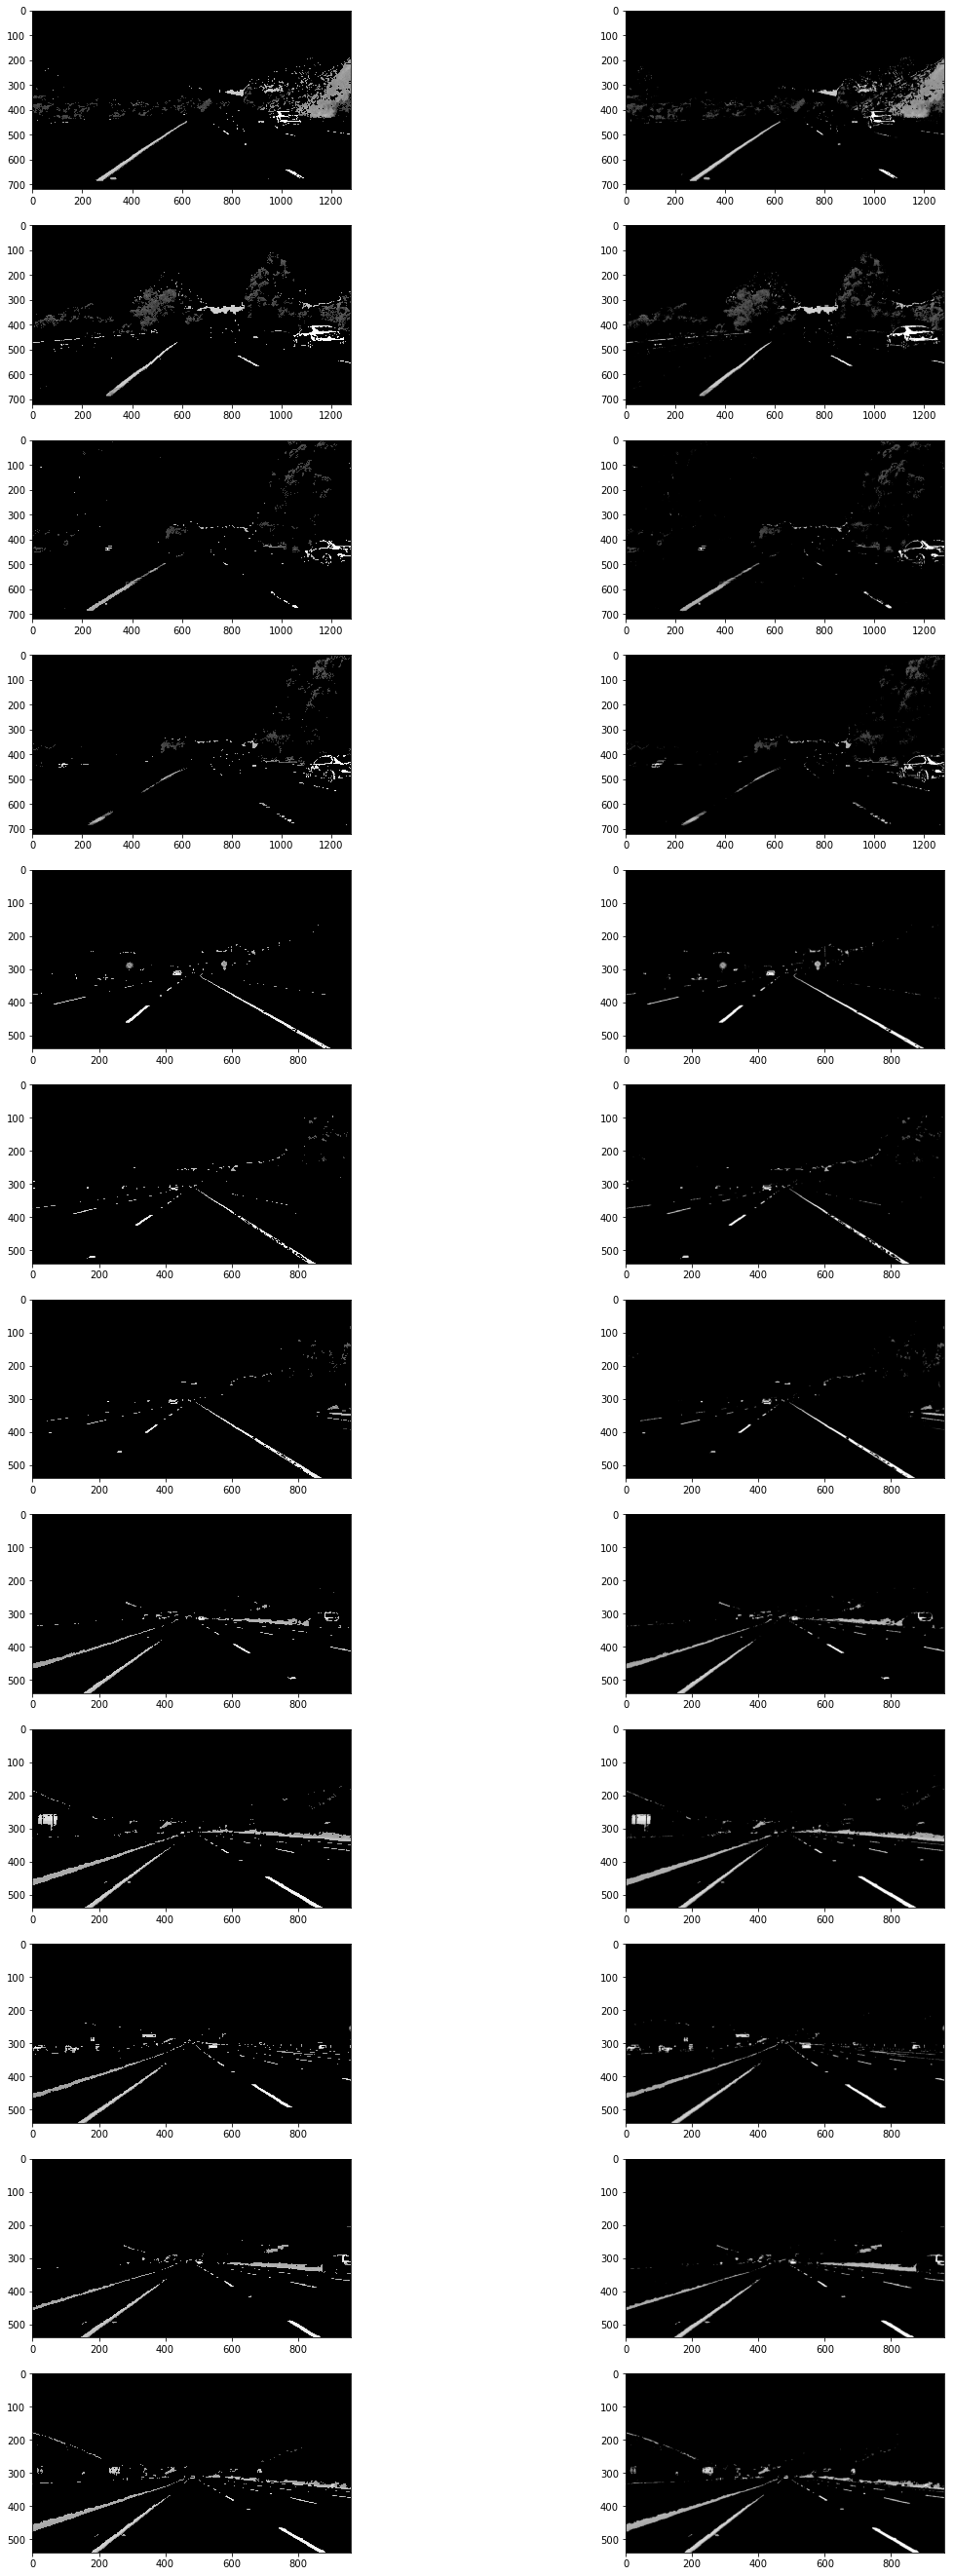

In [15]:
blur_images = [gaussian_blur(gray, 5) for gray in gray_images]
show_images(gray_images, blur_images, save=True, name='blur.png')

### Canny Edge Detecting

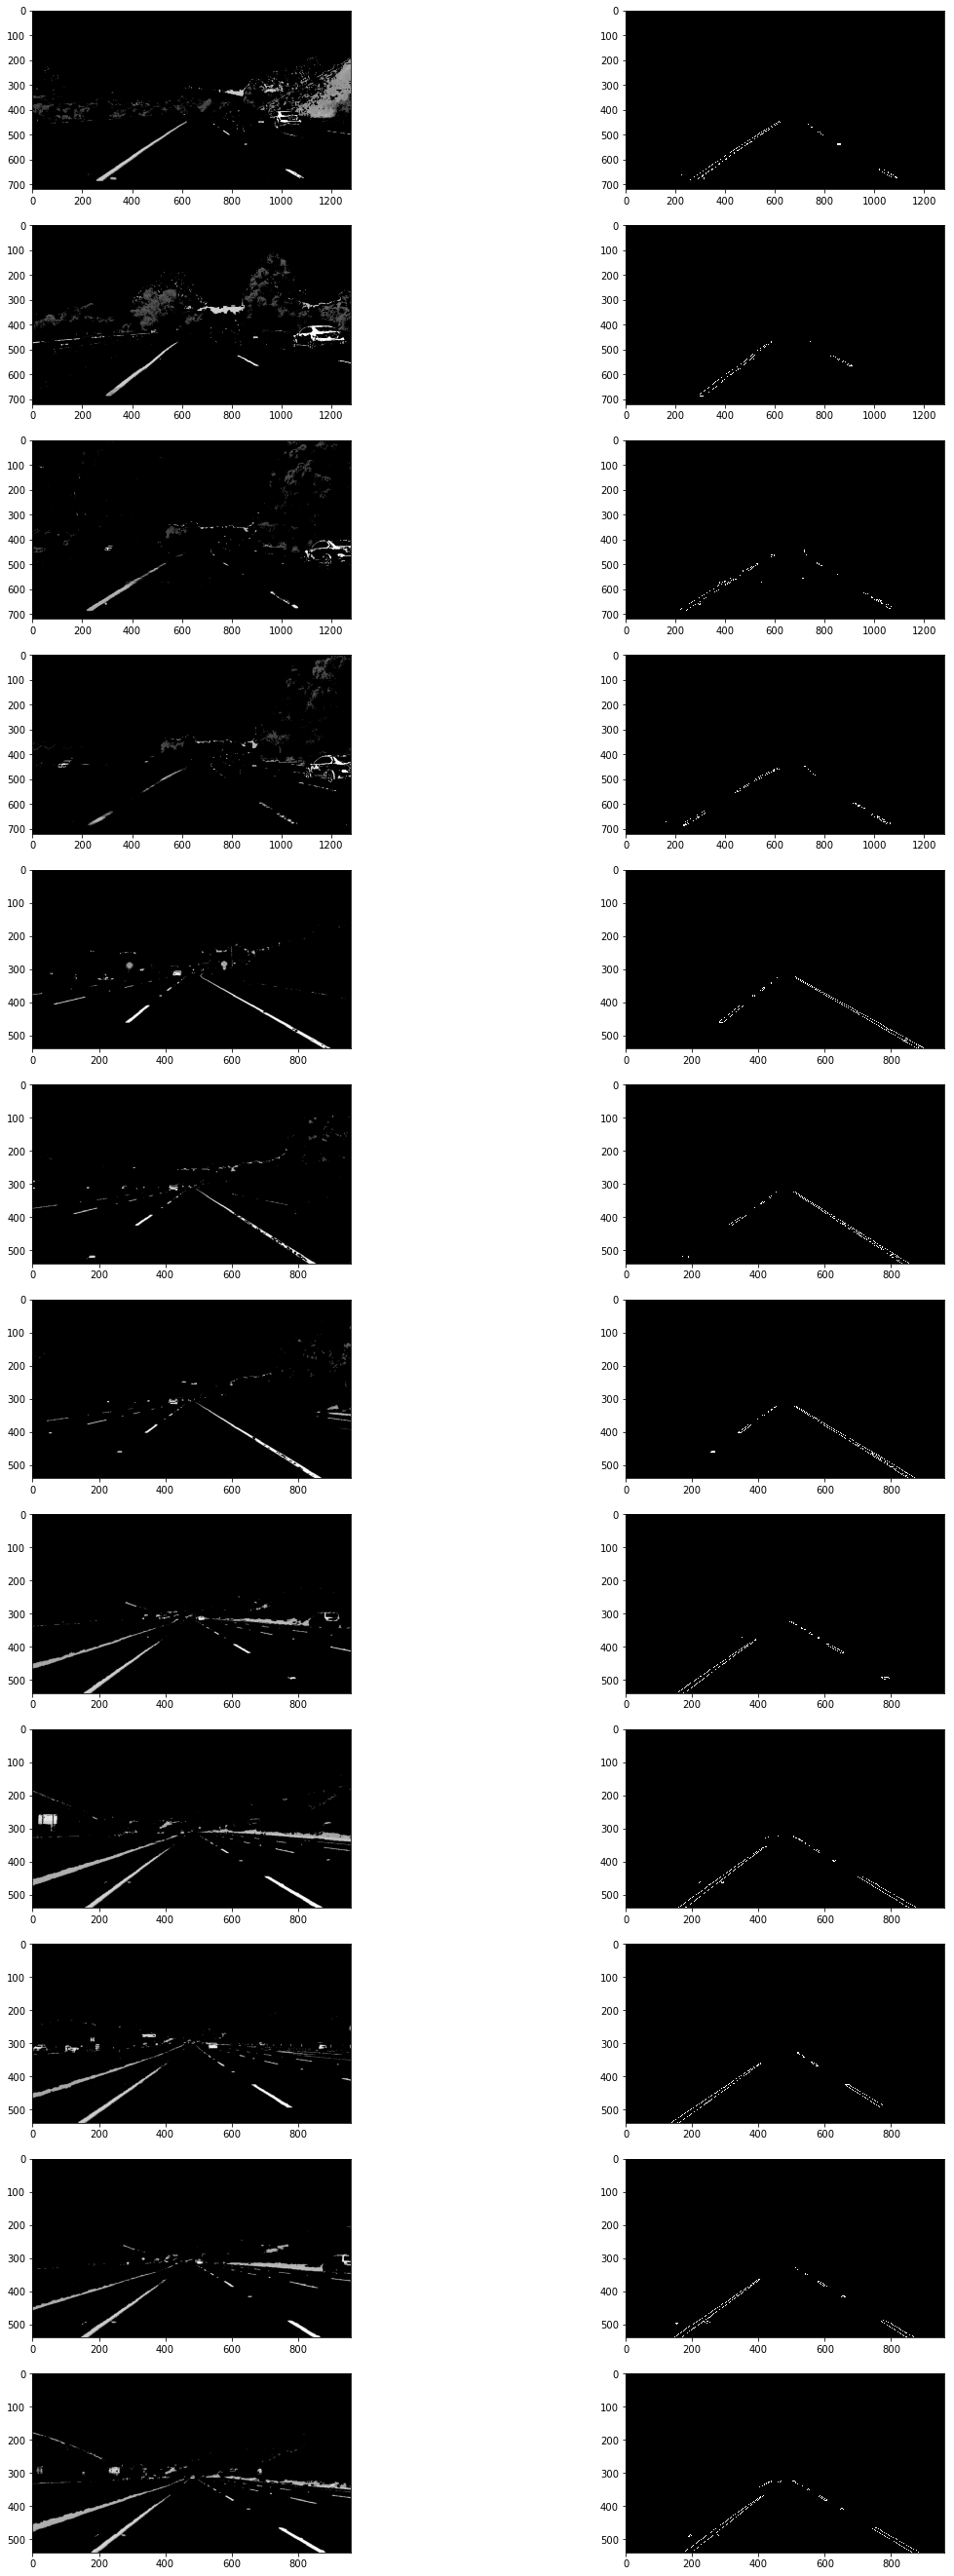

In [16]:
low_threshold = 70
high_threshold = 192
edge_images = [canny(blur_image, low_threshold, high_threshold) for blur_image in blur_images]
interest_images = [region_of_interest(edges, vertices=vertices) for vertices, edges in zip(image_vertices, edge_images)]
show_images(blur_images, interest_images, save=True, name='edge.png')

## Draw Lines

Draw a line using the lines acquired with the hough transform, averaging and using the maximum length to estimate the type of line. Thick lines are solid lines and thin lines are segment lines.

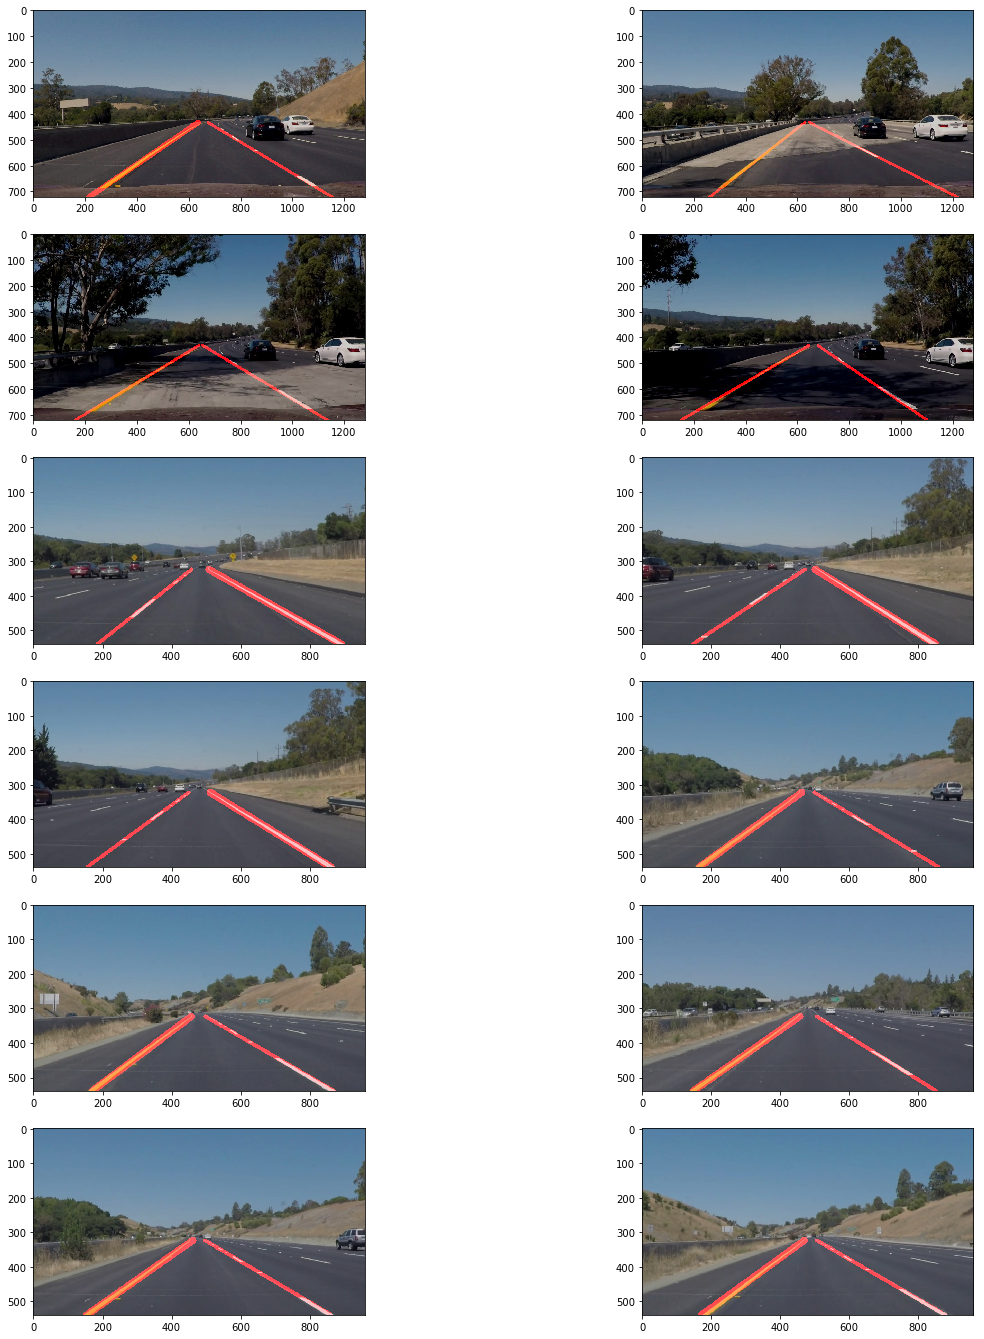

In [17]:
def process_image(image):
    
    low_threshold = 64
    high_threshold = 192
    vertices = get_lane_vertices(image.shape[1], image.shape[0])

    filtered_image = select_white_yellow(image)    
    gray_image = grayscale(filtered_image)
    blur_image = gaussian_blur(gray_image, 5)
    edge_image = canny(blur_image, low_threshold, high_threshold)

    interest_image = region_of_interest(edge_image, vertices=vertices)
    
    # hough transform
    lines = hough_lines(interest_image)
    
    # get a average line and longest line length
    left, right, l_length, r_length  = average_slope_intercept(lines)
    
    # extend each line
    left_line = extend_line(image, left)
    right_line = extend_line(image, right)
    
    # dwaring line
    line_image = np.zeros_like(image)
    left_thickness = 20 if l_length > 200 else 10
    right_thickness = 20 if r_length > 200 else 10
    final_left = draw_line(line_image, left_line, thickness=left_thickness)
    final = draw_line(final_left, right_line, thickness=right_thickness)
    
    # return weighted images
    return  weighted_img(final, image, α=0.8)

final_images = [process_image(image) for image in sample_images]
show_images(final_images, save=True, name='final.png')

## Test on Videos

Process the entire video frames using prepared process function and save it.

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Video processing with white solid line.

In [19]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:08<00:00, 26.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 8.91 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Video processing with yellow solid line.

In [21]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:26<00:00, 25.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 28 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Improvement

If you look at the previous video, the detected line will only react to each individual image. Consider the continuity of the video and try to improve to take advantage of the average of 300ms. ### maintain an average value between images, I need a object holding value for the entire video. We need objects to store the values so that we can refer to the information generated in previous frames.

In [23]:
from collections import deque

QUEUE_LENGTH=8 # sample video has 24fps.

class LaneLineFinder:
    def __init__(self, witdh, height):
        self.left_lines  = deque(maxlen=QUEUE_LENGTH)
        self.right_lines = deque(maxlen=QUEUE_LENGTH)
        self.left_thickness = deque(maxlen=QUEUE_LENGTH)
        self.right_thickness = deque(maxlen=QUEUE_LENGTH)
        low_threshold = 64
        high_threshold = 192
        self.vertices = get_lane_vertices(witdh, height)

    def mean_line(self, line, lines):
        if line is not None:
            lines.append(line)

        if len(lines)>0:
            return np.mean(lines, axis=0, dtype=np.int32)
    
    def mean_line_thickness(self, thickness, history):
        if thickness is not None:
            history.append(thickness)

        if len(history)>0:
            return np.mean(history, axis=0, dtype=np.int32)
    
    
    def process(self, image):
        
        filtered_image = select_white_yellow(image)    
        
        gray_image = grayscale(filtered_image)
        blur_image = gaussian_blur(gray_image, 5)
        edge_image = canny(blur_image, low_threshold, high_threshold)
        
        interest_image = region_of_interest(edge_image, vertices=self.vertices)
        lines = hough_lines(interest_image)

        left, right, l_length, r_length  = average_slope_intercept(lines)
    
        left_line = extend_line(image, left)
        right_line = extend_line(image, right)

        # frame averaging
        left_line  = self.mean_line(left_line, self.left_lines)
        right_line = self.mean_line(right_line, self.right_lines)
        
        line_image = np.zeros_like(image)

        left_thickness = self.mean_line_thickness(20 if l_length > 200 else 8, self.left_thickness)
        right_thickness = self.mean_line_thickness(20 if r_length > 200 else 8, self.right_thickness)
        final_left = draw_line(line_image, left_line, thickness=left_thickness)
        final_right = draw_line(final_left, right_line, thickness=right_thickness)

        return  weighted_img(final_right, image, α=0.8)

# refine to process_video from process_image

It helps you to process your video through the class you created earlier.

In [24]:
def process_video(video_input, video_output):
    clip = VideoFileClip(video_input)
    
    finder = LaneLineFinder(clip.w, clip.h)
    
    processed = clip.fl_image(finder.process)
    processed.write_videofile(video_output, audio=False)

Video processing with white solid line.

In [25]:
white_input = "test_videos/solidWhiteRight.mp4"
white_output = 'test_videos_output/solidWhiteRight-2.mp4'

%time process_video(white_input, white_output)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight-2.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight-2.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:08<00:00, 25.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight-2.mp4 

Wall time: 10.1 s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Video processing with solid yellow line.

In [27]:
yellow_input = 'test_videos/solidYellowLeft.mp4'
yellow_output = 'test_videos_output/solidYellowLeft-2.mp4'

%time process_video(yellow_input, yellow_output)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft-2.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft-2.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:19<00:00, 34.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft-2.mp4 

Wall time: 20.7 s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

Video processing with complicated video ( tree shadow, rode color changed, Etc. )

In [29]:
challenge_input = 'test_videos/challenge.mp4'
challenge_output = 'test_videos_output/challenge.mp4'

%time process_video(challenge_input, challenge_output)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:12<00:00, 21.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 13.9 s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))